In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [6]:
# Save the last 21 days 
test_data = data[-21*24:]
data = data[:-21*24]

# Separate the data into features and targets
#target_fields = ['cnt', 'casual', 'registered']
target_fields = ['cnt']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [7]:
features = features.values
targets = targets.values
test_features = test_features.values
test_targets = test_targets.values

In [8]:
# Hold out the last 60 days of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [9]:
print("features ", train_features.shape)
print("labels", train_targets.shape)
print (train_targets[0:2, :])

features  (15435, 58)
labels (15435, 1)
[[-0.95631172]
 [-0.82399838]]


In [10]:
x = tf.placeholder(tf.float32, shape=[None, train_features.shape[1]], name = 'x')
y = tf.placeholder(tf.float32, shape=[None, train_targets.shape[1]], name = 'y')
k = tf.placeholder(tf.float32, name='keep_prob')
x.shape

TensorShape([Dimension(None), Dimension(58)])

In [20]:
hiden_nodes = 4
output_nodes = 1
layer = tf.contrib.layers.fully_connected(x, hiden_nodes, activation_fn=tf.sigmoid)
preds = tf.contrib.layers.fully_connected(layer, output_nodes, activation_fn=None)
preds.shape

TensorShape([Dimension(None), Dimension(1)])

In [21]:
cost = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y, preds))))
optimizer = tf.train.AdamOptimizer().minimize(cost)

In [22]:

def get_batch(x, y, size):
    for b in range(len(x)//size):
        
        yield x[b*size:(b+1)*size, :], y[b*size:(b+1)*size, :]

In [23]:
batch_size = 128
epochs = 32

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    print (val_features.shape)
    # Training cycle
    for epoch in range(epochs):
        for batch_features, batch_labels in get_batch(train_features, train_targets, batch_size):
            
            sess.run(optimizer, feed_dict = {x: batch_features, y: batch_labels})
        
        
        val_cost = sess.run(cost, feed_dict={x:val_features, y:val_targets})
        print ("valid_cost:", val_cost)
    cost, y_ = sess.run([cost,preds], feed_dict={x:test_features, y:test_targets}) 
    print ("test cost", cost)

(1440, 58)
valid_cost: 1.09333
valid_cost: 0.894806
valid_cost: 0.74709
valid_cost: 0.635902
valid_cost: 0.560154
valid_cost: 0.504761
valid_cost: 0.454607
valid_cost: 0.408018
valid_cost: 0.369851
valid_cost: 0.340403
valid_cost: 0.315581
valid_cost: 0.292726
valid_cost: 0.272344
valid_cost: 0.255229
valid_cost: 0.241322
valid_cost: 0.230446
valid_cost: 0.22001
valid_cost: 0.209086
valid_cost: 0.203938
valid_cost: 0.194189
valid_cost: 0.189113
valid_cost: 0.18203
valid_cost: 0.177587
valid_cost: 0.176784
valid_cost: 0.189075
valid_cost: 0.16531
valid_cost: 0.185481
valid_cost: 0.157499
valid_cost: 0.169025
valid_cost: 0.148934
valid_cost: 0.149026
valid_cost: 0.14663
test cost 0.0602278


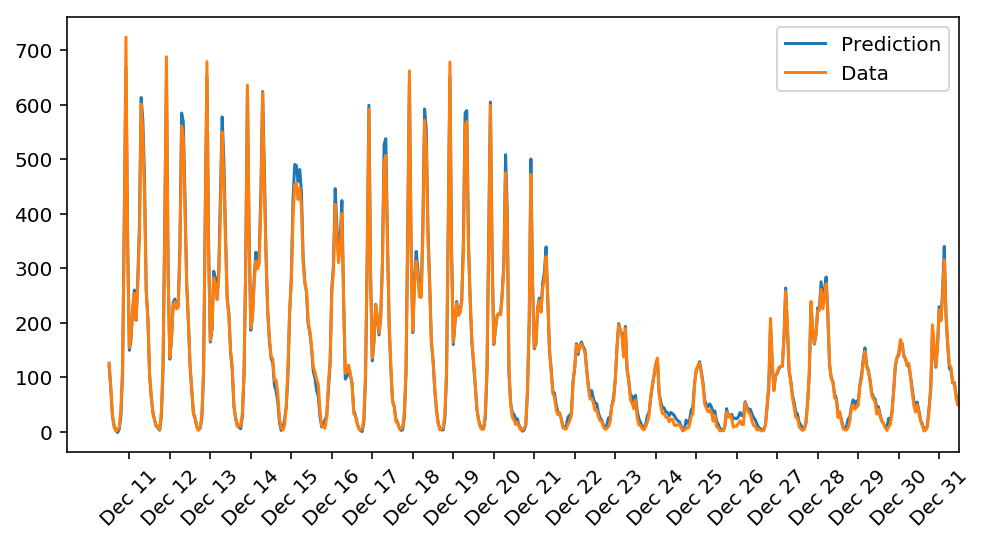

In [24]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = y_*std + mean
ax.plot(predictions, label='Prediction')
ax.plot((test_targets*std + mean), label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)